<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

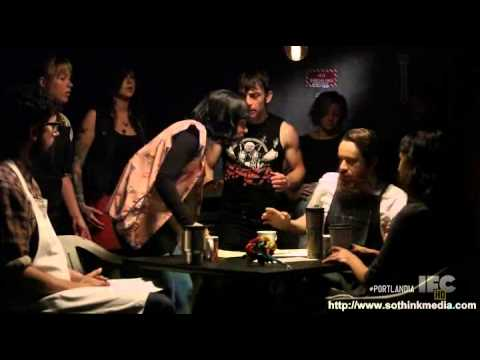

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/josephbell/Desktop/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [444]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
print(shops.shape)
shops.head()

(7616, 3)


,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [422]:
# Start here 

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [453]:
# Removing dates from review text
shops['full_review_text'] = shops['full_review_text'].str.split(n=1).str[1]
shops['full_review_text'] = shops['full_review_text'].str.rstrip('1')
shops['full_review_text'] = shops['full_review_text'].str.rstrip('check-in')

In [454]:
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,love loved the atmosphere! Every corner of the...,5.0 star rating
1,The Factory - Cafe With a Soul,"Night: Austin, Ambiance in Austin BEAUTIFUL!!!...",4.0 star rating
2,The Factory - Cafe With a Soul,in Brunch Spots I loved the eclectic and homey...,4.0 star rating
3,The Factory - Cafe With a Soul,Good drinks Nice seating However... Just abo...,2.0 star rating
4,The Factory - Cafe With a Soul,are located within the Northcross mall shoppin...,4.0 star rating


In [455]:
shops['full_review_text']

0       love loved the atmosphere! Every corner of the...
1       Night: Austin, Ambiance in Austin BEAUTIFUL!!!...
2       in Brunch Spots I loved the eclectic and homey...
3       Good drinks Nice seating  However...  Just abo...
4       are located within the Northcross mall shoppin...
                              ...                        
7611    into this restaurant by chance and now is one ...
7612    Room IS awesome. How do they have so many grea...
7613    for tea, and the atmosphere was pretty and fre...
7614    just average. The booths didn't feel very clea...
7615    in for lunch with my colleague and I'm so glad...
Name: full_review_text, Length: 7616, dtype: object

In [456]:
# create bad coffee shops column with ratings 1-3 and 
# good coffe shops column with ratings 4-5

shops['rating'] = shops['star_rating'].str.split(n=1).str[0]
shops['rating'] = pd.to_numeric(shops['rating'])
shops['good'] = shops['rating'] >= 4.0
shops.head()

,coffee_shop_name,full_review_text,star_rating,rating,good
0,The Factory - Cafe With a Soul,love loved the atmosphere! Every corner of the...,5.0 star rating,5.0,True
1,The Factory - Cafe With a Soul,"Night: Austin, Ambiance in Austin BEAUTIFUL!!!...",4.0 star rating,4.0,True
2,The Factory - Cafe With a Soul,in Brunch Spots I loved the eclectic and homey...,4.0 star rating,4.0,True
3,The Factory - Cafe With a Soul,Good drinks Nice seating However... Just abo...,2.0 star rating,2.0,False
4,The Factory - Cafe With a Soul,are located within the Northcross mall shoppin...,4.0 star rating,4.0,True


In [457]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [458]:
shops['tokens'] = shops['full_review_text'].apply(tokenize)

In [459]:
shops['tokens'].head()

0    [love, loved, the, atmosphere, every, corner, ...
1    [night, austin, ambiance, in, austin, beautifu...
2    [in, brunch, spots, i, loved, the, eclectic, a...
3    [good, drinks, nice, seating, however, just, a...
4    [are, located, within, the, northcross, mall, ...
Name: tokens, dtype: object

In [460]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
shops['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[('the', 34136),
 ('and', 26462),
 ('a', 22375),
 ('i', 19015),
 ('to', 16985),
 ('of', 12488),
 ('is', 11489),
 ('coffee', 9872),
 ('was', 9547),
 ('it', 9333)]

In [461]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [462]:
STOP_WORDS = nlp.Defaults.stop_words.union(['coffee', 'Austin', 'austin', "' '"])

In [463]:
# Wrap it all in a function
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON') and token.text.lower() not in STOP_WORDS:
            lemmas.append(token.lemma_)
    
    return lemmas

In [464]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [465]:
shops['lemmas'].head()

0    [love, love, atmosphere, corner, shop, style, ...
1    [night, Ambiance, beautiful, love, ambiance, I...
2    [Brunch, Spots, love, eclectic, homey, plush, ...
3    [good, drink, nice, seating,  ,  , overpriced,...
4    [locate, Northcross, mall, shopping, center, f...
Name: lemmas, dtype: object

In [466]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [468]:
# Use the Function
wc = count(shops['lemmas'])

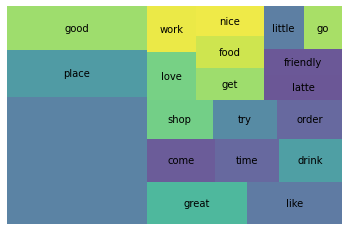

In [470]:
# Use the Function
wc = count(shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [471]:
wc.head(6)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
5,,4327,14885,1.0,0.042579,0.042579,0.568146
98,place,3652,5625,2.0,0.016090,0.058669,0.479517
146,good,3417,5085,3.0,0.014546,0.073215,0.448661
136,great,2593,3525,4.0,0.010083,0.083298,0.340467
166,like,2240,3319,5.0,0.009494,0.092792,0.294118
422,come,1851,2511,6.0,0.007183,0.099975,0.243041


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [474]:
# Use the Function
wc = count(shops['lemmas'].where(shops['good']==True))
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

TypeError: 'float' object is not iterable

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

